🔍 Buscando mejores hiperparámetros…
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



✨ Mejores hiperparámetros:
  mlp__alpha: 0.001
  mlp__batch_size: 32
  mlp__hidden_layer_sizes: (128, 64, 32)
  mlp__learning_rate_init: 0.0001
🎯 Accuracy CV medio: 0.7543

✅ Accuracy en test: 0.7465

📋 Reporte de clasificación:
              precision    recall  f1-score   support

      104102       0.42      0.38      0.40        37
      104103       0.25      0.07      0.11        29
      111401       0.00      0.00      0.00        30
      114102       0.57      0.67      0.62        58
      114103       0.58      0.29      0.39        38
      114121       0.46      0.33      0.38        49
      114122       0.55      0.77      0.64       138
      114123       0.56      0.22      0.31        87
      114131       0.45      0.79      0.57        57
      114132       0.00      0.00      0.00        29
       14221       0.71      0.79      0.75        73
       14222       0.45      0.14      0.22        35
       14231       0.50      0.13      0.21        31
       14262 

C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

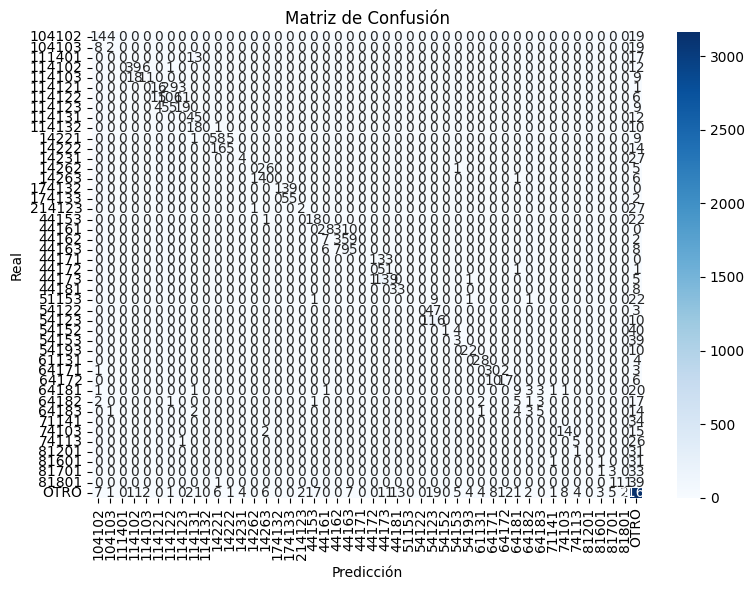

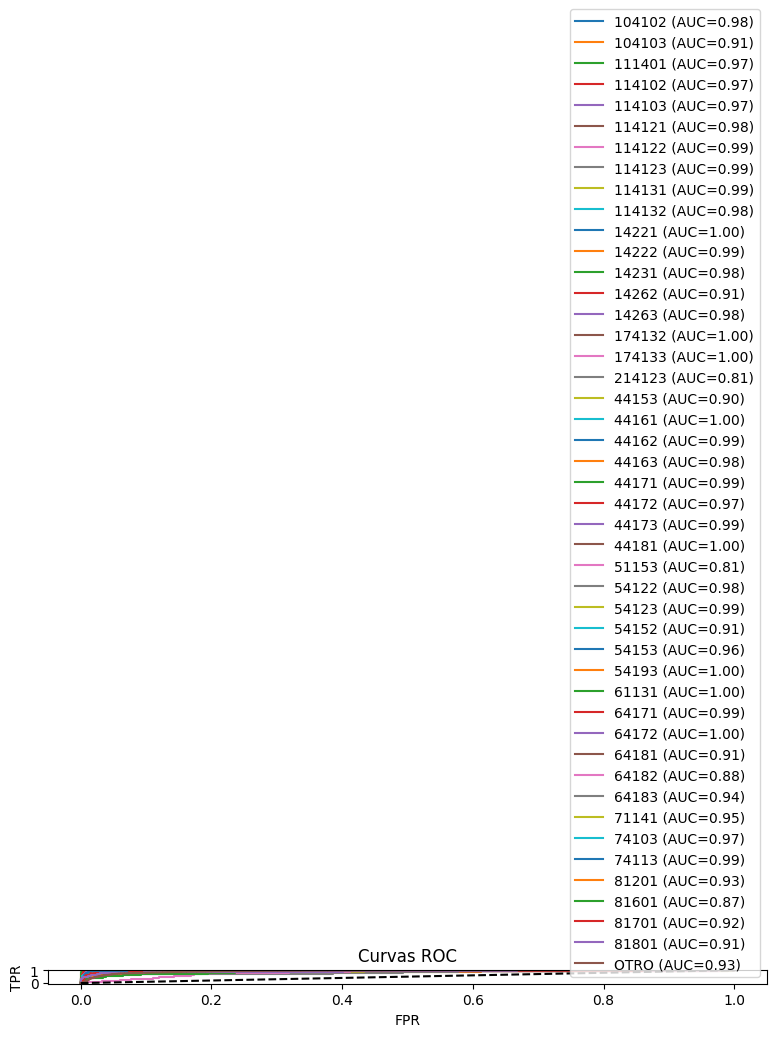

⚠️ No alcanzaste 90%. Puedes probar con más o menos componentes PCA, o ajustar aún más los hiperparámetros.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # --- AJUSTA RUTA AL EXCEL ---
    INPUT_PATH = "datos_modelo_GRD.xlsx"
    if not os.path.exists(INPUT_PATH):
        raise FileNotFoundError(f"No encontré el archivo Excel en: {INPUT_PATH}")

    # 1. Carga y 2. Imputación
    df = pd.read_excel(INPUT_PATH)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna('Desconocido', inplace=True)

    # 3. Selección de variables antes del alta médica
    features = [
        'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
        'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
        'Num_Procedimientos', 'Tipo servicio'
    ]
    X = df[features]

    # 4. Filtrar GRDs poco frecuentes
    y_raw = df['GRD -Código'].astype(str)
    counts = y_raw.value_counts()
    umbral = counts.max() * 0.20
    frecuentes = counts[counts >= umbral].index
    y = y_raw.where(y_raw.isin(frecuentes), 'OTRO')

    # 5. One-hot + LabelEncoding
    X = pd.get_dummies(X, drop_first=True)
    le = LabelEncoder()
    y = le.fit_transform(y)

    # 6. Eliminar clases rara vez representadas (un solo ejemplar)
    clase_counts = Counter(y)
    mask = [clase_counts[val] > 1 for val in y]
    X = X.loc[mask, :]
    y = np.array(y)[mask]

    # 7. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # 8. Pipeline con PCA fijo a 50 componentes
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)),  # reduce a 50 dims
        ('mlp', MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=42,
            max_iter=50,
            verbose=False
        ))
    ])

    # 9. GridSearchCV sobre hiperparámetros
    param_grid = {
        'mlp__hidden_layer_sizes': [(128,64), (128,64,32), (128,64,32)],
        'mlp__alpha': [1e-4, 1e-3, 1e-2],
        'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2],
        'mlp__batch_size': [32, 64],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        pipeline, param_grid,
        cv=cv, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    print("🔍 Buscando mejores hiperparámetros…")
    grid.fit(X_train, y_train)

    print("\n✨ Mejores hiperparámetros:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"🎯 Accuracy CV medio: {grid.best_score_:.4f}")

    # 10. Evaluación en test
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy en test: {acc:.4f}")

    print("\n📋 Reporte de clasificación:")
    print(classification_report(
        y_test, y_pred,
        target_names=le.inverse_transform(np.arange(len(le.classes_)))
    ))

    # 11. Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.inverse_transform(np.arange(len(le.classes_))),
                yticklabels=le.inverse_transform(np.arange(len(le.classes_))))
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # 12. Curvas ROC
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(le.inverse_transform(np.arange(len(le.classes_)))):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba[:,i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc='lower right')
    plt.title("Curvas ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.show()

    # 13. Comprobación del 90%
    if acc >= 0.90:
        print("🎉 ¡Lograste ≥90% de accuracy!")
    else:
        print("⚠️ No alcanzaste 90%. Puedes probar con más o menos componentes PCA, o ajustar aún más los hiperparámetros.")

if __name__ == "__main__":
    main()


In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # --- AJUSTA RUTA AL EXCEL ---
    INPUT_PATH = "datos_modelo_GRD.xlsx"
    if not os.path.exists(INPUT_PATH):
        raise FileNotFoundError(f"No encontré el archivo Excel en: {INPUT_PATH}")

    # 1. Carga y 2. Imputación
    df = pd.read_excel(INPUT_PATH)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna('Desconocido', inplace=True)

    # 3. Selección de variables antes del alta médica
    features = [
        'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
        'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
        'Num_Procedimientos', 'Tipo servicio'
    ]
    X = df[features]

    # 4. Filtrar GRDs poco frecuentes
    y_raw = df['GRD -Código'].astype(str)
    counts = y_raw.value_counts()
    umbral = counts.max() * 0.20
    frecuentes = counts[counts >= umbral].index
    y = y_raw.where(y_raw.isin(frecuentes), 'OTRO')

    # 5. One-hot + LabelEncoding
    X = pd.get_dummies(X, drop_first=True)
    le = LabelEncoder()
    y = le.fit_transform(y)

    # 6. Eliminar clases con una sola muestra
    clase_counts = Counter(y)
    mask = [clase_counts[val] > 1 for val in y]
    X = X.loc[mask, :]
    y = np.array(y)[mask]

    # 7. División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # 8. Pipeline (sin PCA, sin SMOTE)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            activation='relu',
            solver='adam',
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=42,
            max_iter=150,
            verbose=False
        ))
    ])

    # 9. GridSearchCV de hiperparámetros
    param_grid = {
        'mlp__hidden_layer_sizes': [(256, 128, 64), (128, 64, 32), (512, 256, 128)],
        'mlp__alpha': [1e-5, 1e-4, 1e-3],
        'mlp__learning_rate_init': [5e-4, 1e-3, 5e-3],
        'mlp__batch_size': [16, 32, 64],
        'mlp__learning_rate': ['adaptive', 'constant']
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        pipeline, param_grid,
        cv=cv, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    print("🔍 Buscando mejores hiperparámetros…")
    grid.fit(X_train, y_train)

    print("\n✨ Mejores hiperparámetros:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"🎯 Accuracy CV medio: {grid.best_score_:.4f}")

    # 10. Evaluación en test
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy en test: {acc:.4f}")

    print("\n📋 Reporte de clasificación:")
    print(classification_report(
        y_test, y_pred,
        target_names=le.inverse_transform(np.arange(len(le.classes_)))
    ))

    # 11. Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.inverse_transform(np.arange(len(le.classes_))),
                yticklabels=le.inverse_transform(np.arange(len(le.classes_))))
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # 12. Curvas ROC
    y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(le.inverse_transform(np.arange(len(le.classes_)))):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba[:,i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc='lower right', fontsize='small')
    plt.title("Curvas ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.show()

    # 13. Comprobación del 90%
    if acc >= 0.90:
        print("🎉 ¡Lograste ≥90% de accuracy!")
    else:
        print("⚠️ No alcanzaste 90%. Revisa si puedes añadir más variables o ajustar el umbral de GRDs frecuentes.")

if __name__ == "__main__":
    main()


🔍 Buscando mejores hiperparámetros…
Fitting 5 folds for each of 162 candidates, totalling 810 fits
